## <center> **Анализ результатов A/B-тестирования**

Компания планирует запустить новую акцию, чтобы продать как можно больше туров. Команда разработала два варианта посадочной страницы официального сайта компании и провела A/B-тестирование. Собранные в результате проведения эксперимента данные вы можете найти здесь.

Вам предстоит решить настоящую бизнес-задачу: проанализировать эффективность обоих вариантов посадочной страницы сразу по двум критериям: конверсии покупки и среднему чеку. На основе проведенного анализа вам будет необходимо сделать выводы и принять решение: какой из вариантов дизайна более предпочтительный.

Итак, наша фирма предлагает следующие варианты туров и их соответствующие стоимости:
* Таиланд — 100000 рублей;
* Турция — 60000 рублей;
* Мальдивы — 200000 рублей;
* Санкт-Петербург — 10000 рублей;
* Камчатка — 150000 рублей.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import ttest_ind, shapiro, f_oneway, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest

Прочитаем наши данные и посмотрим на столбцы таблицы:

In [2]:
data = pd.read_csv('data/ab_data_tourist.csv')
data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


## **Задание 7.1.**

Начнем с исследования структуры наших данных. С помощью метода info() выведите информацию о типах данных и количестве непустых значений. Какой тип данных имеет столбец date?

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


## **Задание 7.2.**

Приведите столбец date к типу данных datetime. Убедитесь в равной длительности проведения тестирования для каждой из группы. Для этого сгруппируйте данные по признаку группы и определите первую и последнюю дату наблюдения для каждой из групп. 

В какой промежуток времени проводился A/B-тест?


In [4]:
data['date'] = pd.to_datetime(data['date'])
data.groupby('group')['date'].agg(['min', 'max'])

,min,max
group,,
A,2021-01-02,2021-01-24
B,2021-01-02,2021-01-24


## **Задание 7.3.**

* Чему равно количество посещений сайта в группах А и B?

* Чему равно суммарное количество покупок в группах А и B?

* Чему равна сумма всех покупок в группах А и B? Ответ приведите в миллионах рублей. Например, 185.52 млн. руб.

In [5]:
data_group = data.groupby('group')[['purchase', 'price']].agg(['count', 'sum'])
display(data_group)
round(data_group['price']['sum']/1000000, 2)

purchase          price            
         count    sum   count         sum
group                                    
A       147202  17723  147202  1436260000
B       147276  17514  147276  1554100000

group
A    1436.26
B    1554.10
Name: sum, dtype: float64

## **Задание 7.4.**

Проверьте, есть ли пользователи, которые в процессе A/B-теста попали в обе тестовые группы? Если да, то сколько таких уникальных пользователей, если нет - введите в поле для ответа 0?

**Подсказка:**

*Создайте множество пользователей группы А и множество пользователей группы B. Пересеките два этих множества (операция intersection) и вычислите количество элементов в полученном множестве.*


In [6]:
set_A = set(data[data['group'] == 'A']['user_id'])
set_B = set(data[data['group'] == 'B']['user_id'])


user_intersection = set_A.intersection(set_B)
print(len(set_A), len(set_B), len(user_intersection))

146195 146284 1895


## **Исключите пользователей, оказавшихся в обеих группах**

Так как мы не можем определить, какая из версий сайта повлияла на принятие решения, исключим этих пользователей. Далее мы будем работать только с очищенными от пересечений данными.

Возможный вариант исключения пользователей:

In [7]:
updated_data = data[data['user_id'].apply(lambda x: x not in user_intersection)]
updated_data

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000
...,...,...,...,...,...
294473,751197,2021-01-03,A,0,0
294474,945152,2021-01-12,A,0,0
294475,734608,2021-01-22,A,0,0
294476,697314,2021-01-15,A,0,0


Где user_intersection - множество пересечений пользователей групп А и B.

## **Задание 7.5.**

Для первичного анализа результатов A/B-тестирования нам понадобится таблица следующего вида:

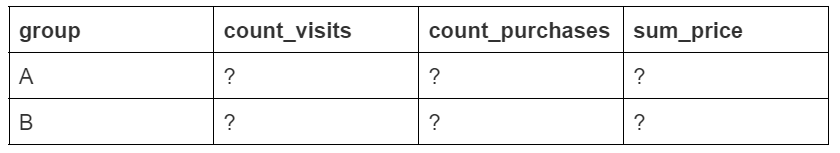
 
 
Для того, чтобы получить такую таблицу, сгруппируйте данные по признаку группы. В каждой группе рассчитайте следующие показатели:
* количество посещений (количество пользователей)
* количество совершенных покупок
* сумма всех покупок в группе

В полученной сгруппированной таблице переименуйте столбцы на **count_visits, count_purchases и sum_price**.

**Подсказка:**

*Для переименования столбцов можно использовать метод rename() с параметром columns, в который передается словарь. Ключи этого словаря - старые имена столбцов, а значения - новые.*

Чему на этот раз равно количество посещений сайта в группах А и B?


In [8]:
updated_data_group = updated_data.groupby('group').agg(['count', 'sum'])
updated_data_group = updated_data_group.iloc[:, [0, 3, 5]]
updated_data_group.columns = updated_data_group.columns.map('_'.join)
updated_data_group = updated_data_group.rename(columns={
    'user_id_count':'count_visits',
    'purchase_sum':'count_purchases',
    'price_sum':'sum_price'
    })

updated_data_group

C:\Users\User\AppData\Local\Temp\ipykernel_33348\4092629324.py:1: FutureWarning: ['date'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  updated_data_group = updated_data.groupby('group').agg(['count', 'sum'])


,count_visits,count_purchases,sum_price
group,,,
A,145307,17487,1417780000
B,145381,17290,1533010000


Приведите промежуточные выводы по построенной таблице. Сопоставимо ли количество посещений обоих вариантов посадочной странице, можно ли говорить о сбалансированности выборок?

Можно сделать промежуточные выводы, что количество посещений обоих вариантов сопоставимо, выборки сбалансированы.

## **Задание 7.6.**

Добавьте в сгруппированную таблицу столбцы conversion - конверсия покупки (отношение количества покупок к количеству посещений сайта в каждой группе, выраженное в процентах) и mean_check - средний чек (отношение суммы покупок к количеству покупок в каждой группе).

* Чему равна конверсия в группах? Ответ приведите в процентах и округлите до сотых. Например, 75.12 %
* Чему равен средний чек в группах? Ответ приведите в рублях и округлите до целых. Например, 120519 рублей.

In [9]:
updated_data_group['conversion'] = round(updated_data_group['count_purchases'] / updated_data_group['count_visits'] * 100, 2)
updated_data_group['mean_check'] = round(updated_data_group['sum_price'] / updated_data_group['count_purchases'], 0)
updated_data_group

,count_visits,count_purchases,sum_price,conversion,mean_check
group,,,,,
A,145307,17487,1417780000,12.03,81076.0
B,145381,17290,1533010000,11.89,88665.0


Приведите промежуточные выводы по таблице. По какому(им) показателю(ям) вариант А эффективнее варианта B и наоборот?

Пока что кажется что обе группы выглядят очень похожими, в группе А незначительно выше конверсия, в группе В незначительно выше средний чек.

## **Задание 7.7.**

Теперь давайте сравним варианты по покупательской способности туров. Для этого постройте сводную таблицу, которая покажет зависимость количества продаж от группы и цены тура. 

In [10]:
pivot_data = updated_data.pivot_table(
    values= 'purchase',
    index= 'group',
    columns= 'price',
    aggfunc= 'sum'
)
pivot_data

price,0,10000,60000,100000,150000,200000
group,,,,,,
A,0,5182,5271,1832,3478,1724
B,0,5201,1730,5227,3438,1694


Визуализируйте полученную сводную таблицу с помощью тепловой карты с аннотацией. 
Чему равно количество проданных туров за 60000 рублей в группах?

<AxesSubplot: xlabel='price', ylabel='group'>

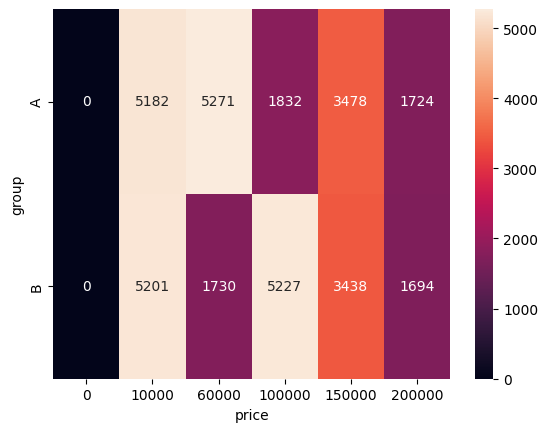

In [11]:
sns.heatmap(pivot_data, annot=True, fmt=".0f")

Сделайте выводы по построенной таблице. По каким турам покупательская способность участников группы А выше, чем участников группы B и наоборот?

Покупательская способность группы А выше по турам с ценой 60000.

## **Задание 7.8.**

Настало время поговорить о стабилизации кумулятивных метрик во времени. Но прежде, чем перейти к кумулятивным метрикам, нам необходимо построить таблицу с ежедневными данными результатов проведения A/B-тестирования.

Сгруппируйте данные по дате и группе тестирования. В каждой группе вычислите количество посещений страницы, количество покупок и сумму покупок. 

Добавьте в таблицу информацию о ежедневной конверсии (ежедневное количество покупок / ежедневное количество посещений) в группе и ежедневном среднем чеке (ежедневная сумма покупок / ежедневное количество покупок)
* Чему равна конверсия 3 января 2021 года? Ответ приведите в процентах и округлите до сотых.

* Чему равен средний чек 3 января 2021 года? Ответ приведите в рублях и округлите до целого.

In [12]:
# Все расчеты для группы А
updated_data_A = updated_data[updated_data['group'] == 'A']
updated_data_A_group = updated_data_A[[
    'date', 'purchase','price']].groupby('date', as_index=False).agg(['count', 'sum'])

updated_data_A_group = updated_data_A_group.iloc[:, 1: ]
updated_data_A_group.columns = updated_data_A_group.columns.map('_'.join)

# Добавьте в таблицу информацию о ежедневной конверсии 
# (ежедневное количество покупок / ежедневное количество посещений) в группе
updated_data_A_group['conversion'] = round(updated_data_A_group[
    'purchase_sum'] / updated_data_A_group['price_count'] * 100, 2)

# и ежедневном среднем чеке (ежедневная сумма покупок / 
# ежедневное количество покупок
updated_data_A_group['mean_check'] = round(updated_data_A_group[
    'price_sum'] / updated_data_A_group['purchase_sum'])
updated_data_A_group.reset_index(inplace= True )


# Аналогичная группировка для группы В
updated_data_B = updated_data[updated_data['group'] == 'B']
updated_data_B_group = updated_data_B[[
    'date', 'purchase','price']].groupby('date', as_index=False).agg(['count', 'sum'])
updated_data_B_group

updated_data_B_group = updated_data_B_group.iloc[:, 1: ]
updated_data_B_group.columns = updated_data_B_group.columns.map('_'.join)

updated_data_B_group['conversion'] = round(updated_data_B_group[
    'purchase_sum'] / updated_data_B_group['price_count'] * 100, 2)

updated_data_B_group['mean_check'] = round(updated_data_B_group[
    'price_sum'] / updated_data_B_group['purchase_sum'])
updated_data_B_group.reset_index(inplace= True )

# Чему равна конверсия 3 января 2021 года? 
# Ответ приведите в процентах и округлите до сотых.
# Чему равен средний чек 3 января 2021 года? 
# Ответ приведите в рублях и округлите до целого.

print('Для группы A')
print(updated_data_A_group[updated_data_A_group['date'] == '2021-01-03'][[
    'date','conversion','mean_check']])
print()
print('Для группы В')
print(updated_data_B_group[updated_data_B_group['date'] == '2021-01-03'][[
    'date','conversion','mean_check']])

Для группы A
        date  conversion  mean_check
1 2021-01-03       11.34     82888.0

Для группы В
        date  conversion  mean_check
1 2021-01-03       11.39     87480.0


## **Задание 7.9.** 

Добавьте в таблицу с ежедневными показателями кумулятивные признаки:
* кумулятивное количество посещений страницы
* кумулятивное количество покупок
* кумулятивную сумму покупок

Не забудьте при расчете кумулятивной суммы сгруппировать данные по группам. 

Вычислите кумулятивную конверсию и кумулятивный средний чек на основе полученных кумулятивных показателей. 

* Какая **кумулятивная** конверсия была в группе B на 20 января? Ответ приведите в процентах, округлив до сотых.
* Какой **кумулятивный** средний чек был в группе А на 12 января 2021 года? Ответ приведите в рублях, округлив до целых.

In [13]:
A_group = updated_data_A_group

A_group['cum_vizits'] = A_group['price_count'].cumsum()
A_group['cum_purchase_sum'] = A_group['purchase_sum'].cumsum()
A_group['cum_price_sum'] = A_group['price_sum'].cumsum()
A_group['cum_conversion'] = A_group['cum_purchase_sum'] / A_group['cum_vizits'] * 100
A_group['cum_mean_check'] = round(A_group['cum_price_sum'] / A_group['cum_purchase_sum'])

B_group = updated_data_B_group

B_group['cum_vizits'] = B_group['price_count'].cumsum()
B_group['cum_purchase_sum'] = B_group['purchase_sum'].cumsum()
B_group['cum_price_sum'] = B_group['price_sum'].cumsum()
B_group['cum_conversion'] = round(B_group['cum_purchase_sum'] / B_group['cum_vizits'] * 100, 2)
B_group['cum_mean_check'] = round(B_group['cum_price_sum'] / B_group['cum_purchase_sum'])
display(B_group.head())

a = A_group[A_group['date'] == '2021-01-12']['cum_mean_check']
b = B_group[B_group['date'] == '2021-01-20']['cum_conversion']

print(f'кумулятивная конверсия в группе B на 20 января {b}')
print(f'кумулятивный средний чек в группе А на 12 января {a}')


,date,purchase_sum,price_count,price_sum,conversion,mean_check,cum_vizits,cum_purchase_sum,cum_price_sum,cum_conversion,cum_mean_check
0,2021-01-02,345,2861,29660000,12.06,85971.0,2861,345,29660000,12.06,85971.0
1,2021-01-03,754,6619,65960000,11.39,87480.0,9480,1099,95620000,11.59,87006.0
2,2021-01-04,764,6536,68030000,11.69,89045.0,16016,1863,163650000,11.63,87842.0
3,2021-01-05,749,6511,63550000,11.50,84846.0,22527,2612,227200000,11.59,86983.0
4,2021-01-06,838,6751,75020000,12.41,89523.0,29278,3450,302220000,11.78,87600.0


кумулятивная конверсия в группе B на 20 января 18    11.9
Name: cum_conversion, dtype: float64
кумулятивный средний чек в группе А на 12 января 10    81492.0
Name: cum_mean_check, dtype: float64


Постройте кумулятивные графики конверсии и среднего чека в каждой группе по дням. Сделайте выводы. Можно ли назвать A/B-тест завершенным - стабилизировались ли значения метрик во времени? Как соотносятся кумулятивные показатели в каждой группе?

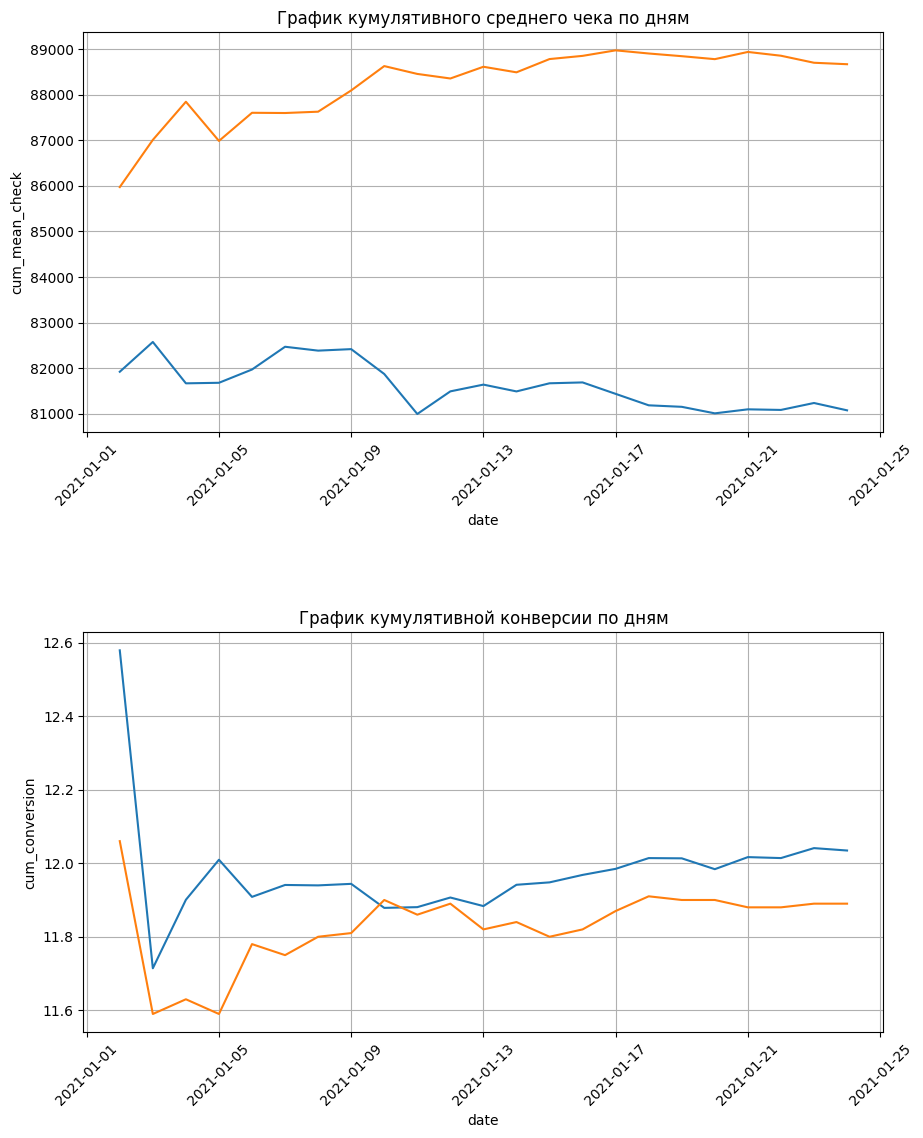

In [14]:
# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4))
# добавляем систему координат
ax1 = fig.add_axes([1, 1, 1, 1])
ax2 = fig.add_axes([1, 2.5, 1, 1])
# строим lineplot для кумулятивной конверсии во времени в каждой группе
sns.lineplot(x='date', y='cum_conversion', data=A_group, ax=ax1)
sns.lineplot(x='date', y='cum_conversion', data=B_group, ax=ax1)
sns.lineplot(x='date', y='cum_mean_check', data=A_group, ax=ax2)
sns.lineplot(x='date', y='cum_mean_check', data=B_group, ax=ax2)
# задаём подпись к графику
ax1.set_title('График кумулятивной конверсии по дням')
ax2.set_title('График кумулятивного среднего чека по дням')
# задаём поворот меток на оси абсцисс
ax1.xaxis.set_tick_params(rotation = 45)
ax2.xaxis.set_tick_params(rotation = 45)
# задаём отображение сетки
ax1.grid(True)
ax2.grid(True);

Метрики перешли в паралели, то есть стабилизировались.
Куммулятивная конверсия в группах различается крайне незначительно.
Куммулятивный средний чек в группе B стабильно выше, чем в группе А.

## **Задание 7.10.**

Настало время переходить к проверке статистической значимости разницы между метриками в группах. Начнем с конверсии.

Какой тест вы примените для проверки гипотезы о равенстве конверсий в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Конверсии в группах А и B равны; 
* $H_1$: Конверсия в группе А больше чем конверсия в группе B;

Вычислите p-value вашего теста для конверсий в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$=0.05. 

In [15]:
# Нулевая и альтернативная гипотезы
H0 = 'Конверсии в группах А и В равны'
H1 = 'Конверсия в группе А больше, чем конверсия в группе В'
alpha = 0.05 # уровень значимости
# вычисляем значение p-value для z-теста
_, p_value = proportions_ztest(
    count=updated_data_group['count_purchases'], # Число успехов
    nobs=updated_data_group['count_visits'], # общее число наблюдений
    alternative='larger',
)
# Выводим результат на экран
print('p-value: ', round(p_value, 2))
# сравниваем полученное p_value с уровнем значимости
if (p_value < alpha):
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. Н1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value:  0.12
Принимаем нулевую гипотезу. Конверсии в группах А и В равны


Приведите свои выводы по результатам проведенного статистического теста. Есть ли статистическая разница между конверсиями в группах А и B?

P_value > alpha, значит, мы не отвергаем нулевую гипотезу. То есть Конверсии в группах А и В равны.

## **Задание 7.11.**
Убедитесь в своих рассуждениях, построив 95%-ый доверительный интервал для конверсий и разницы между ними. Используйте $z_{крит}$ в своих расчетах

Укажите нижнюю и верхнюю границы доверительных интервалов. Границы приведите в процентах и округлите до 2 знака после запятой. Например: нижняя граница 89.24%, верхняя граница 91.25%.

In [16]:
from scipy.stats import norm

def proportions_conf_interval(n, x_p, gamma=0.95):   
    alpha = 1 - gamma # уровень значимости
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (x_p * (1 - x_p) / n) ** 0.5 #погрешность
    lower_bound = x_p - eps # левая (нижняя) граница
    upper_bound = x_p + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound * 100, 2), round(upper_bound * 100, 2)

In [17]:
a_data = updated_data_group.loc['A']
b_data = updated_data_group.loc['B']

In [18]:
conf_interval_a = proportions_conf_interval(
n=a_data['count_visits'], # размер выборки
x_p=a_data['conversion']/100 # выборочная пропорция
)
conf_interval_b = proportions_conf_interval(
n=b_data['count_visits'], # размер выборки
x_p=b_data['conversion']/100 # выборочная пропорция
)
print('Доверительный интервал для конверсии группы А: {}'.format(conf_interval_a))
print('Доверительный интервал для конверсии группы B: {}'.format(conf_interval_b))

Доверительный интервал для конверсии группы А: (11.86, 12.2)
Доверительный интервал для конверсии группы B: (11.72, 12.06)


In [19]:
# Функция разности доверительных интервалов

def diff_proportions_conf_interval(n, xp, gamma=0.95):
    alpha = 1 - gamma # уровень значимости
    diff = xp[1] - xp[0] # выборочная разница конверсий групп B и A
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (xp[0] * (1 - xp[0])/n[0] + xp[1] * (1 - xp[1])/n[1]) ** 0.5 # погрешность
    lower_bound = diff - eps # левая (нижняя) граница
    upper_bound = diff + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound * 100, 2), round(upper_bound * 100, 2)


In [20]:
# размеры выборок групп А и B
n = [a_data['count_visits'], b_data['count_visits']]
# выборочная пропорция групп A и B
xp = [a_data['conversion']/100, b_data['conversion']/100]
# строим доверительный интервал для разности конверсий
diff_inverval = diff_proportions_conf_interval(n, xp)
print('Доверительный интервал для разности конверсий: {}'.format(diff_inverval))

Доверительный интервал для разности конверсий: (-0.38, 0.1)


Проинтерпретируйте построенные доверительные интервалы для конверсий в группах. Есть ли перекрытие между доверительными интервалами для групп? Есть ли статистическая разница между конверсиями в группах А и B?

Выводы:
Построенный доверительный интервал с 95 %-ой надёжностью говорит нам, что разница в конверсии между вариантом B и вариантом А лежит в интервале от -0.38 % до 0.1 %. То есть разница в конверсии с 95 %-ой надёжностью может быть как положительной, так и отрицательной. Отсюда можно сделать выводы, что статистической разницы по данной метрике нет.

## **Задание 7.12.**

Ранее мы построили таблицу с ежедневными показателями. Теперь она нам снова понадобится, так как нас интересует ежедневный средний чек.

Проверьте гипотезу о нормальности распределения ежедневного среднего чека в каждой из групп тестирования. 

* Какой тест вы примените  для проверки гипотезы о нормальности распределения ежедневного среднего чека?
* Как будут звучать нулевая и альтернативная гипотезы?
* Каковы результаты статистического теста с уровнем значимости $\alpha$ =0.05?

In [24]:
# Применю тест Шапиро-Уилка

from scipy.stats import shapiro
# нулевая и альтернативная гипотезы
H0 = 'Распределения в обеих группах нормальные'
H1 = 'Распределение в одной или обеих группах отлично от нормального'
alpha = 0.05 # уровень значимости
# вычисляем результат теста Шапиро-Уилка для выборок
shapiro_result_a = shapiro(A_group['mean_check'])
shapiro_result_b = shapiro(B_group['mean_check'])
print('p-value группы А', round(shapiro_result_a.pvalue, 2))
print('p-value группы B', round(shapiro_result_b.pvalue, 2))
# сравниваем полученное p-value с уровнем значимости
if shapiro_result_a.pvalue < alpha or shapiro_result_b.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value группы А 0.25
p-value группы B 0.09
Принимаем нулевую гипотезу. Распределения в обеих группах нормальные


## **Задание 7.13.**
Настало время сравнить варианты дизайна страницы по метрике среднего чека. 

Какой тест вы примените для проверки гипотезы о равенстве средних чеков по дням в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Ежедневные средние чеки в группах А и B равны; 
* $H_1$: Ежедневный средний чек в группе А меньше чем в группе B;

Вычислите p-value вашего теста для ежедневного среднего чека в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$ =0.05. 

In [26]:
# Распределение в обеих группах нормальное, количество дней менее 30, 
# поэтому, проведем Т-тест

from scipy.stats import ttest_ind
# нулевая и альтернативная гипотезы
H0 = 'Средний чек в группах одинаковый'
H1 = 'Средний чек в группе А меньше, чем в группе B'
alpha = 0.05 #уровень значимости
#вычисляем результат T-теста для выборок
results = ttest_ind(
    a=A_group['mean_check'],
    b=B_group['mean_check'], 
    alternative='less'
)
print('p-value:', round(results.pvalue, 2))
 
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value: 0.0
Отвергаем нулевую гипотезу. Средний чек в группах одинаковый
Альтернативная гипотеза. H1: Средний чек в группе А меньше, чем в группе B


 Приведите свои выводы по проведенному статистическому тесту. Есть ли статистическая разница между ежедневными средними чеками в группах А и B?

In [ ]:
# Статистическая разница среднего чека в группах есть, средний чек в 
# группе А меньше среднего чека в группе В.

## **Задание 7.14.**

Постройте 95%-ый доверительный интервал для среднего чека в каждой группе. Так как выборка средних чеков небольшая, используйте  $t_{крит}$ в своих расчетах.

Укажите нижнюю границу доверительного интервала для истинного среднего чека каждой из групп. Ответ приведите в процентах и округлите до целого.

In [30]:
len(A_group)

23

In [38]:
def t_confidence_interval(n, x_mean, x_std, gamma=0.95):
    # n # размер выборки
    # x_mean # выборочное среднее
    # x_std # выборочное стандартное отклонение
    # gamma # уровень надёжности
    k = n - 1 # число степеней свободы
    alpha = 1 - gamma # уровень значимости
    t_crit = -t.ppf(alpha/2, k) # t-критическое
    eps = t_crit * x_std/(n ** 0.5) # погрешность
    lower_bound = x_mean - eps # левая (нижняя) граница
    upper_bound = x_mean + eps # правая (верхняя) граница
    confidence_interval = (round(lower_bound), round(upper_bound)) # создаём кортеж из округлённых границ интервала
    print('Доверительный интервал: {}'.format(confidence_interval)) # выводим результат
    print(f' eps={eps},\n t_crit={t_crit},\n x_std={x_std},\n \
    n={n},\n x_mean={x_mean}') 

In [39]:
A_group['mean_check'].std()

3096.388506406891

In [41]:
conf_interval_a = t_confidence_interval(
n = len(A_group),
x_mean = A_group['mean_check'].mean(),
x_std = A_group['mean_check'].std()
)

conf_interval_b = t_confidence_interval(
n = len(B_group),
x_mean = B_group['mean_check'].mean(),
x_std = B_group['mean_check'].std()
)

Доверительный интервал: (79630, 82308)
 eps=1338.9787985648686,
 t_crit=2.0738730679040147,
 x_std=3096.388506406891,
     n=23,
 x_mean=80969.34782608696
Доверительный интервал: (87626, 89526)
 eps=949.9268408212644,
 t_crit=2.0738730679040147,
 x_std=2196.7058440349706,
     n=23,
 x_mean=88575.73913043478


Проинтерпретируйте построенные доверительные интервалы для ежедневных средних чеков в группах. Есть ли между ними пересечения?

In [ ]:
# Доверительные интервалы средних чеков групп А и В не пересекаются. 
# С вероятностью 95% среддний чек группы В будет выше чека группы А.

## **Сделайте общий вывод по результатам A/B-теста**

Какой варианта дизайна посадочной страницы является более эффективным в комплексе по метрикам конверсии и среднего чека и почему? 

По итогам исследований по совокупности метрик конверсии и среднего чека более эффективным является дизайн в группе В. По конверсии статистически значимой разныцы не выявлено, но средний чек в группе В стабильно выше, чем в группе А.